In [33]:
from arch.univariate import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
from random import gauss, seed
seed(10)

import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# 02- Volatility prediction: Simulated Data 


$$a_t = \varepsilon_t \sigma_t $$
$$\sigma_t^2 = \omega + \alpha_1 a_{t-1}^2 + \alpha_2 a_{t-2}^2 + \beta_1 \sigma_{t-1}^2 + \beta_2 \sigma_{t-2}^2 $$

$$
a_0, a_1 \sim \mathcal{N}(0,1)
$$

$$
\sigma_0 =1, \sigma_1 = 1
$$

$$
\varepsilon_t \sim \mathcal{N}(0,1)
$$

## Simulate the time series

In [31]:
# create dataset
n = 1000
omega = 0.5

alpha_1 = 0.1
alpha_2 = 0.2

beta_1 = 0.3
beta_2 = 0.4

test_size = int(n*0.1)

series = [gauss(0,1), gauss(0,1)]
vols = [1, 1]

for _ in range(n):
    new_vol = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*vols[-1]**2 + beta_2*vols[-2]**2)
    new_val = gauss(0,1) * new_vol
    
    vols.append(new_vol)
    series.append(new_val)

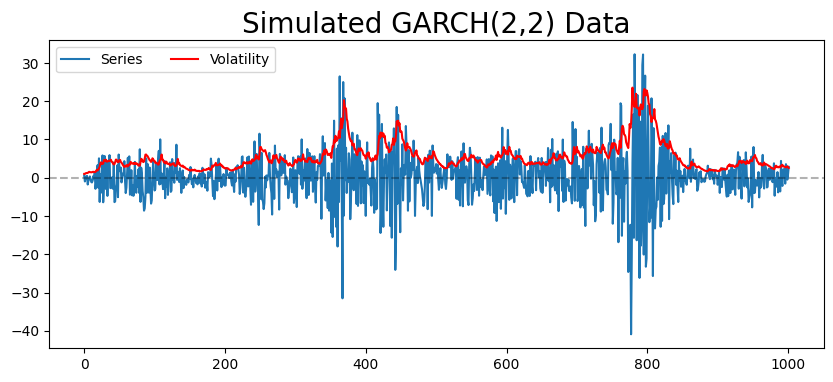

In [32]:
plt.figure(figsize=(10,4))
plt.plot(series, label='Series')
plt.plot(vols, color='red', label='Volatility')
plt.axhline(0, ls='--', alpha=0.3, color='k')
plt.legend(ncol=2, loc='best')
plt.title('Simulated GARCH(2,2) Data', fontsize=20)
plt.show()

## PACF and ACF Plots

Exercise 1: 
* Plot the PACF of the innovation
* Plot the PACF of squared innovation
* What are the two properties you are seeing in the graphs 

Exercise 2: 
* Do the same for the ACF

## Fit and Test models

### Separate the training set from the testing set

In [34]:
train, test = series[:-test_size], series[-test_size:]

### Fit the best GARCH Model= GARCH (2,2)

In [8]:
model = arch_model(train, mean='Zero', p=2, o=0, q=2)

In [9]:
model_fit = model.fit(disp='off')
constant_params = model_fit.params
print(model_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2833.59
Distribution:                  Normal   AIC:                           5677.18
Method:            Maximum Likelihood   BIC:                           5701.21
                                        No. Observations:                  902
Date:                Tue, Apr 18 2023   Df Residuals:                      902
Time:                        14:12:41   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5187      0.216      2.396  1.658e-02 [9.437e-0

fitted_paramters = constant_params.rename('Fitted Parameters').to_frame()
fitted_paramters['true_params'] = [0.5,  0.1, 0.2,  0.3, 0.4]
fitted_paramters

Even when we know the data generating process it is difficult to get back the exact parameters of ARCH
ARCH estimation is based on maximum likelihood. The more there are parameters to estimate, the more difficult it becomes

## Predict

In [11]:
test_size

100

In [12]:
predictions = model_fit.forecast(horizon=test_size)

### Predict the mean ?

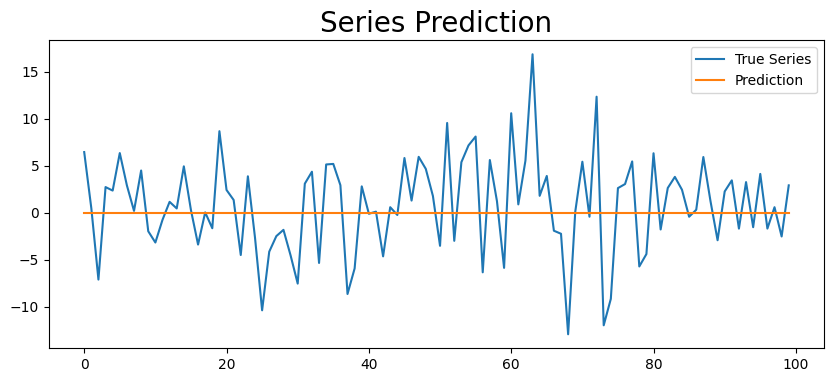

In [13]:
plt.figure(figsize=(10,4))
#true, = plt.plot(series[-test_size:], label='True Series')
true, = plt.plot(series[-test_size:], label='True Series')
preds, = plt.plot(np.sqrt(predictions.mean.values[-1, :]), label='Prediction')

plt.legend(loc='best')
plt.title('Series Prediction', fontsize=20)
plt.show()

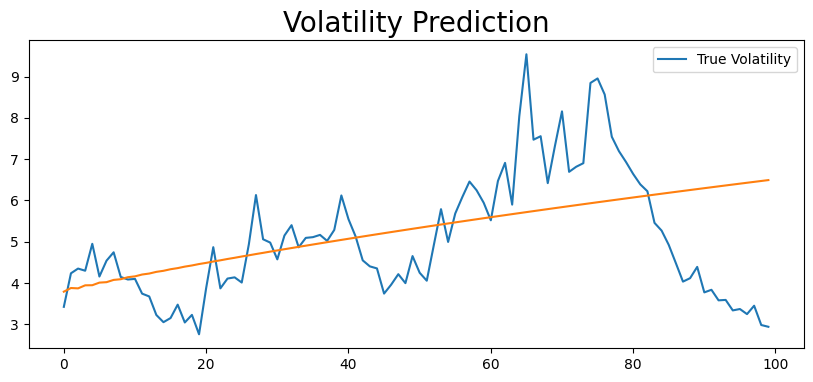

In [14]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:], label='True Volatility')
preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]))

plt.legend(loc='best')
plt.title('Volatility Prediction', fontsize=20)
plt.show()

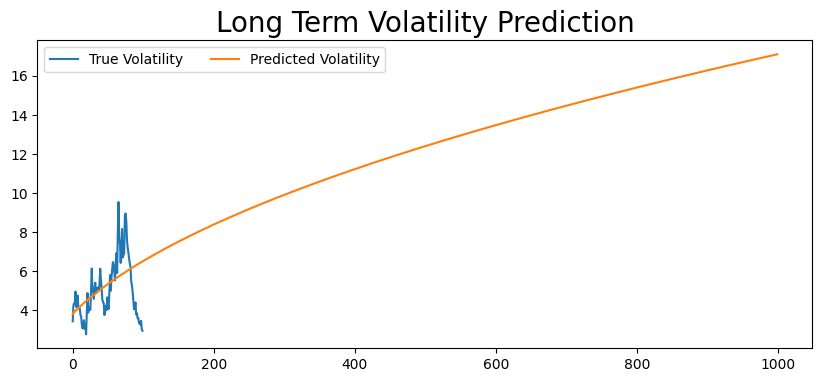

In [15]:
predictions_long_term = model_fit.forecast(horizon=1000)
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:], label='True Volatility')
preds, = plt.plot(np.sqrt(predictions_long_term.variance.values[-1, :]), label='Predicted Volatility')
plt.legend(ncol=2)
plt.title('Long Term Volatility Prediction', fontsize=20)
plt.show()

### Rolling Forecast Origin

In [16]:
rolling_predictions = []
params = {}
for i in tqdm(range(test_size)):
    train = series[:-(test_size-i)]
    model = arch_model(train, mean='Zero', p=2, q=2)
    model_fit = model.fit(disp='off')
    params[i] = model_fit.params
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
params = pd.concat(params.values(), keys=params.keys(), axis=1).T

100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


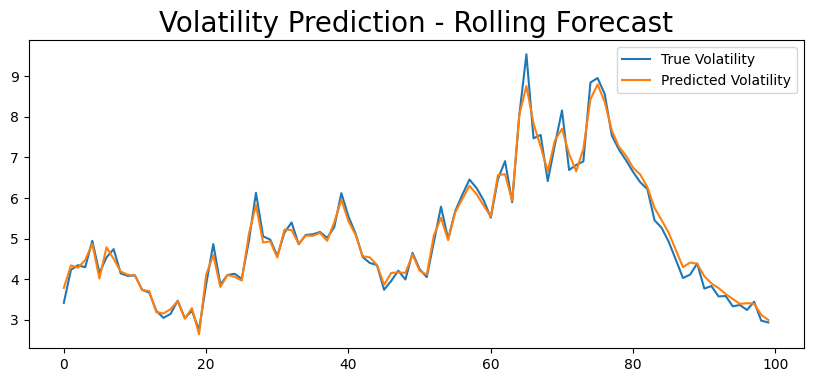

In [17]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:], label = 'True Volatility')
preds, = plt.plot(rolling_predictions, label = 'Predicted Volatility')
plt.legend(loc='best')
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.show()

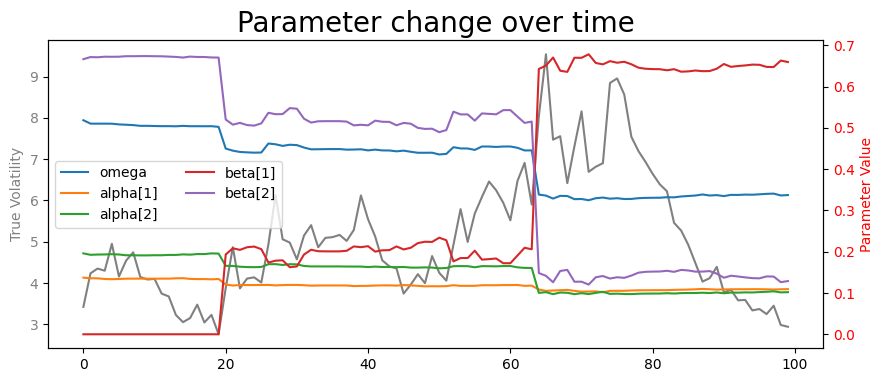

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 4))

# plot the first plot on the left axis
ax1.plot(vols[-test_size:], label='True Volatility', color='grey')
ax1.set_ylabel('True Volatility', color='grey')
ax1.tick_params(axis='y', labelcolor='grey')

# create a twin axis for the second plot on the right
ax2 = ax1.twinx()

# plot the second plot on the right axis
ax2.plot(params)
ax2.set_ylabel('Parameter Value', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# add a title and legend
plt.title('Parameter change over time', fontsize=20)
plt.legend( list(params.columns), ncol=2, loc='best')

plt.show()

### Conclusion

* Note that the GARCH  have no effect on the **conditional mean**, but only on the **conditional volatility**
* The best usage of the Garch model prediction, as any time-series model is to re-estimate the parameters every day and predict **1 step ahead** 
* Parameters update take the recent sudden changes in volatility

### Exercises 1: 
1. Now Fit an ARCH (3) model on the above timeseries 
3. Interprete the results 


### Exercises 1: 
1. Now Fit an GARCH (3,3) model on the above timeseries 
3. Interprete the results 

In [21]:
def generate_process(omega, alphas, betas, sample_size=1000):
    '''
    Generate the process following GARCH (p,q)
    '''
    n = sample_size
    p = len(alphas)
    q = len(betas)
    # Initionalizing the process 
    series = []
    for _ in range(p):
        series.append(gauss(0,1))
        
    vols = list(np.ones(q))

    # Replicate the GARCH dynamic
    for _ in range(n):
        new_var = omega
        for i in range(p):
            new_var = new_var + alphas[i]*series[-1-i]**2
        for i in range(q):
            new_var = new_var + betas[i]*vols[-1-i]**2
        new_vol = np.sqrt(new_var)
        new_val = gauss(0,1) * new_vol

        vols.append(new_vol)
        series.append(new_val)
        
    return vols, series

def plot_process(vols, series, title='Simulated Data'):
    plt.figure(figsize=(10,4))
    plt.plot(series, label='Series')
    plt.plot(vols, color='red', label='Volatility')
    plt.axhline(0, ls='--', alpha=0.3, color='k')
    plt.legend(ncol=2, loc='best')
    plt.title(title, fontsize=20)
    plt.show()

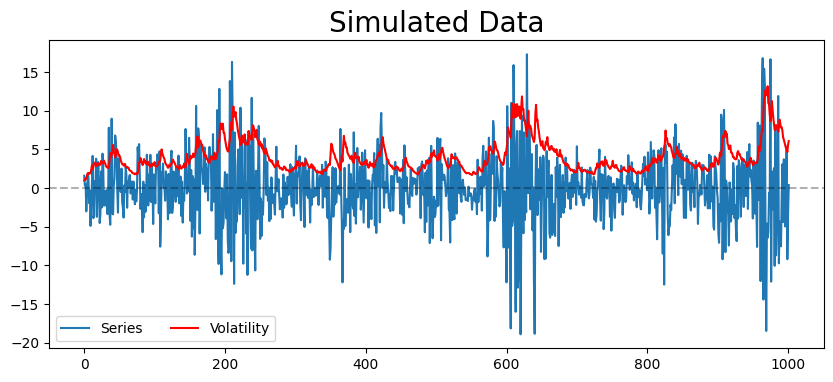

In [22]:
vols, series = generate_process(.5, [0.1, 0.2], [0.3, 0.4]) 
plot_process(vols, series)

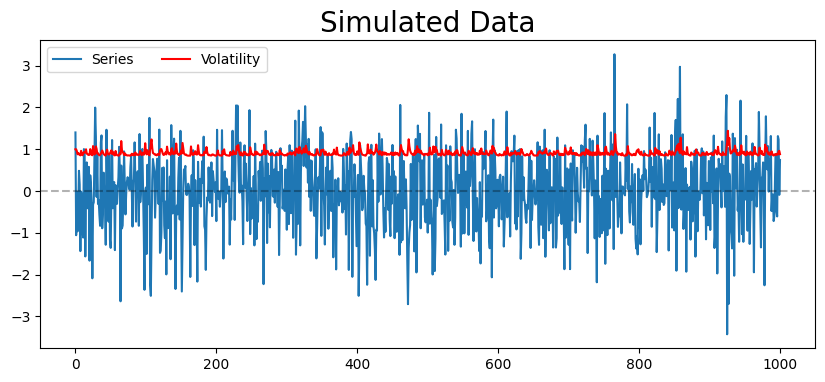

In [28]:
vols, series = generate_process(.5, [0.1], [0.3]) 
plot_process(vols, series)